# Shaking Earth: LANL Earthquake Prediction Challenge

https://www.kaggle.com/c/LANL-Earthquake-Prediction

In LANL Earthquake Prediction Challenge we try to predict time left to the next laboratory earthquake based on seismic signal data. Training data is one huge signal of length more than 629,100,000 (~150,000 x 4194), with 16 earthquakes. In test data we have 2624 separate chunks of length 150,000, for each of which we need to predict time to failure. Test result performance measure is MAE (mean absolute error).

First, we will compress 150,000 original features to 1,500...15,000 features using signal processing and signal compression techniques like FFT and Wavelets. 

Next, we will compute various statistics and norms (maximum, mean, number of peaks/outliers, histograms, wavelet energy at different levels etc.) for the original and compressed signal as well as its FFT coefficients. 

For each feature vector we will compute correlation with the output. Features with correlation > 0.6 and small p-values will be used for clustering and building regression models. 

In [39]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.io as sio
from scipy.stats.stats import pearsonr 
from scipy.stats import spearmanr
from python_speech_features import mfcc
import pywt
import pyarrow as pa
import pyarrow.parquet as pq
import seaborn as sns


%matplotlib inline

## One segment of length 150,000

(150000,)
(150000,)


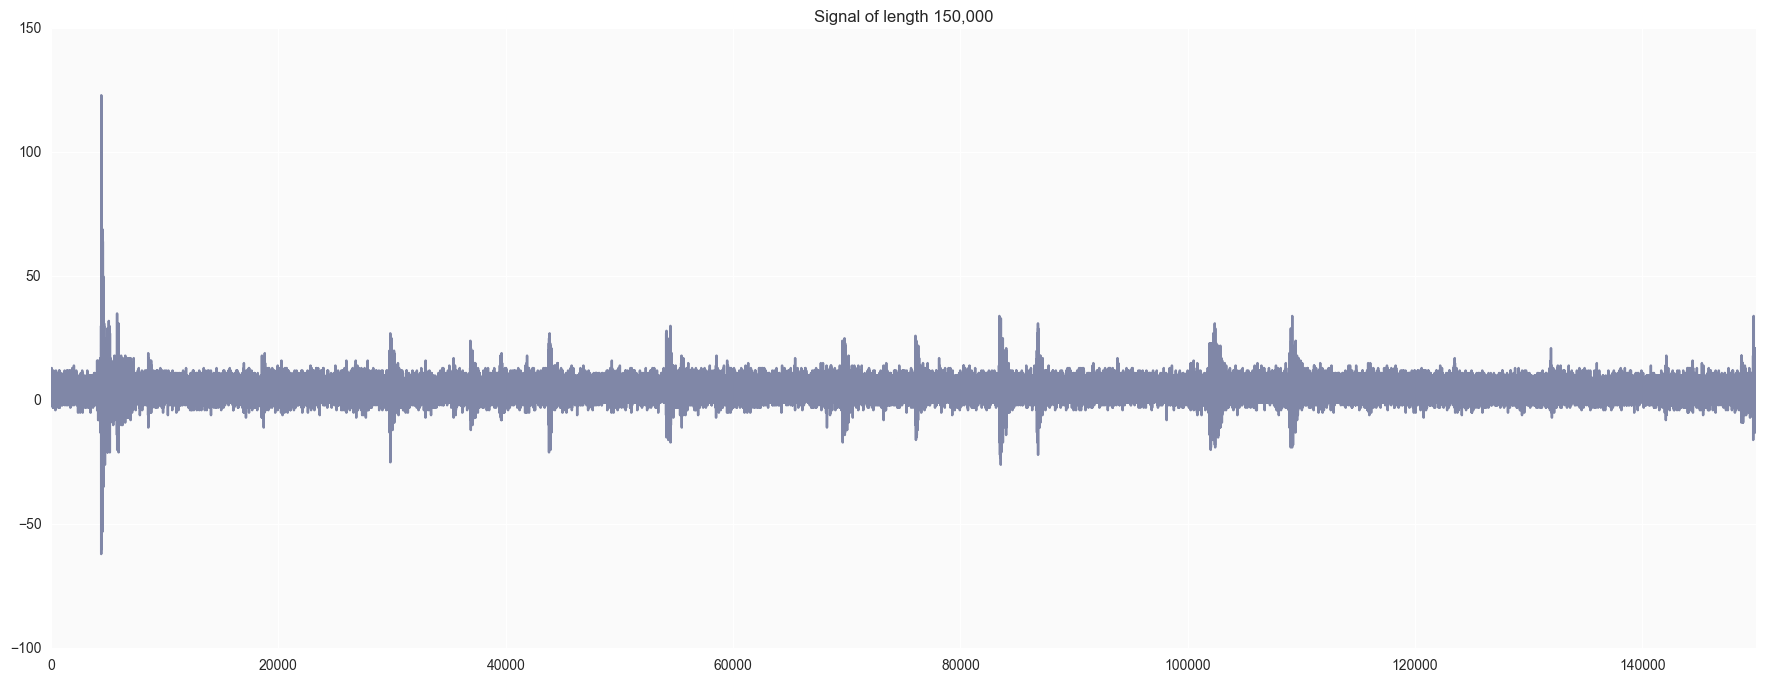

In [20]:
mat_container = sio.loadmat('c:/Users/nely_/A_Projects/Python/ShakingEarth/Train/train1301.mat')
seg = mat_container['seg'].flatten()
print(seg.shape)
tim = mat_container['tim'].flatten()
print(tim.shape)

fig1 = plt.figure(figsize=(22, 8))
ax1 = plt.subplot(1,1,1)
ax1.plot(seg, color='#8087A7')
ax1.set_xlim([0, 150000])
ax1.patch.set_facecolor('#FAFAFA') 
plt.title('Signal of length 150,000')
fig1.savefig('c:/Users/nely_/A_Projects/Python/ShakingEarth/docs/plots/signal_150000.png')

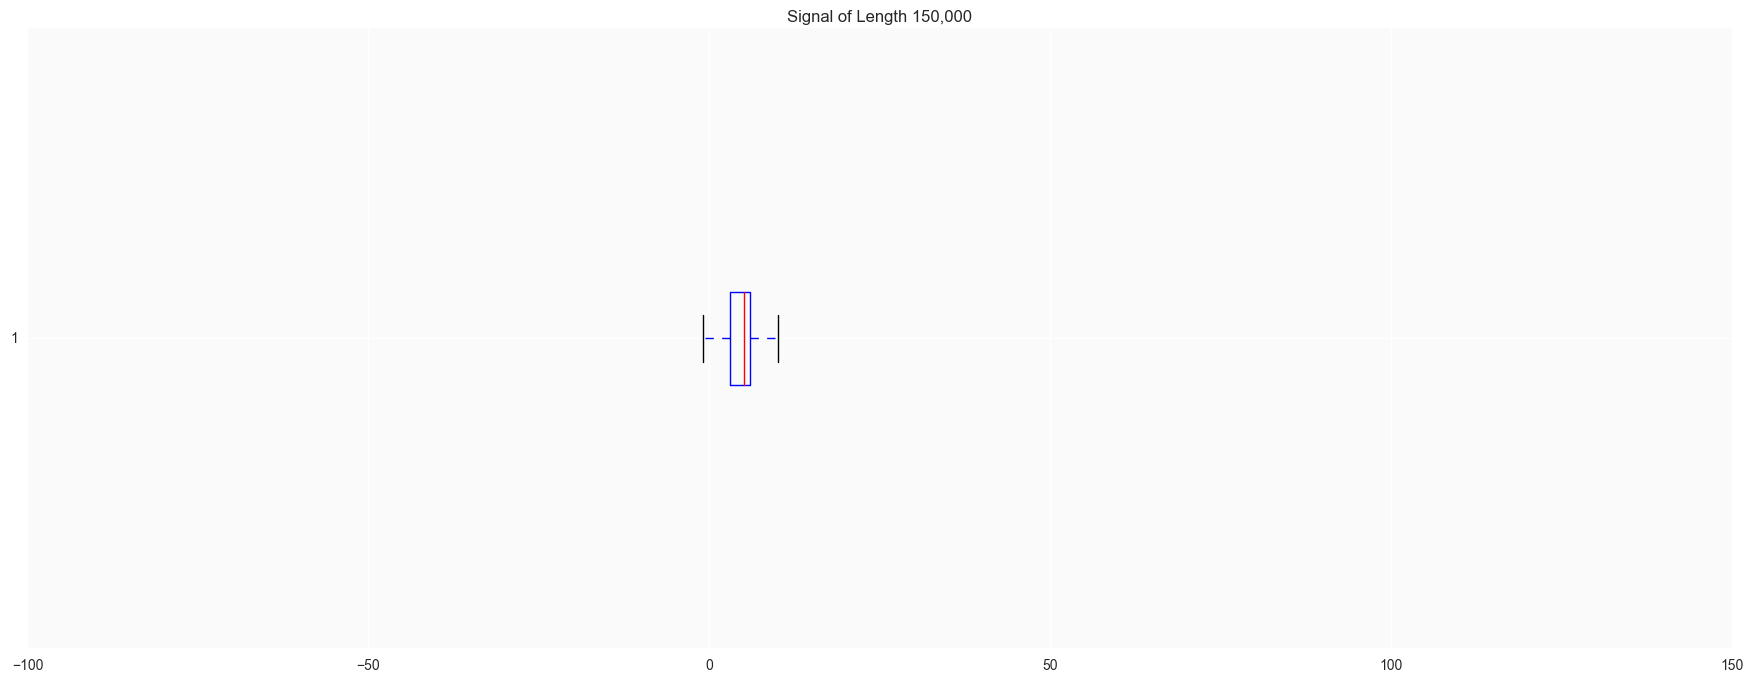

In [21]:
plt.figure(figsize=(22, 8))
ax1 = plt.subplot(1,1,1)
ax1.boxplot(seg,vert=False)
ax1.patch.set_facecolor('#FAFAFA') 
plt.title('Signal of Length 150,000')

Let's compute its FFT

In [ ]:
dim = 150000
fdim = int(dim/2+1)
F = np.abs(np.fft.rfft(seg.astype(float).flatten()) / dim)[1:]
F[1:(fdim-1)] = 2 * F[1:(fdim-1)]
h = np.histogram(F,[0, 1./128, 1./64, 1./32, 1./16, 1./8, 1./4, 1./2, 1.])[0]
print(F[0:10])
print(h)
fig1 = plt.figure(figsize=(22, 8))
ax1 = plt.subplot(1,1,1)
ax1.plot(F, color='#8087A7')
ax1.set_xlim([0, 75000])
ax1.patch.set_facecolor('#FAFAFA') 
plt.title('FFT of Signal of Length 150,000')
fig1.savefig('c:/Users/nely_/A_Projects/Python/ShakingEarth/docs/plots/signal_150000_fft.png')

Let's compute its Haar wavelet

In [31]:
def wavelet_compress(seg):
    # Haar from scratch
    num = len(seg) - len(seg) % 2
    A = (seg[0:num:2] + seg[1:num:2]) * 0.5
    D = (seg[0:num:2] - seg[1:num:2]) * 0.5
    return A, D

if False:
    A, D = pywt.dwt(range(10), 'db1')
    print(pywt.dwt_max_level(150000, 'db1'))
    print(pywt.families())
    print(pywt.wavelist())

## Descriptors

In [32]:
EPS = 2e-15

def count_peaks(seg, factor=[1]):
    q1, q3 = np.percentile(seg,[25,75])
    iqr = (q3 - q1) * 1.5 
    ou = np.zeros(len(factor))
    for i in range(len(factor)):
        ou[i] = ((seg < q1-iqr*factor[i]) | (seg > q3+iqr*factor[i])).sum()
    return ou

def logenergy(x):
    return np.sum(np.log(np.square(x) + EPS))

def shannon(x):
    # Shannon entropy 
    n_x = len(x)
    if n_x <= 1:
        return 0

    value,counts = np.unique(x, return_counts=True)
    probs = counts / n_x
    n_classes = np.count_nonzero(probs)
    if n_classes <= 1:
        return 0

    ent = 0.
    for p in probs:
        ent -= p * np.log(p)
    return ent

def wavelet_energy(c,x):
    # c = A4 or D4 or D3 or D2 or D1
    # x - original signal
    enx = np.sum(np.square(x))
    enc = np.sum(np.square(c))  
    return 100 * enc / enx

def compute_statistics(rec, seg, x_sum_abs, x_sum_sqr, bin_edges=[-10000,-100,-10,0,10,20,50,100,500,10000], dim=150000, bAll=True):
    if bAll:
        snames = ['me','st','ma','mi','ima','imi','di','ame','ast','ama','iama','iamax','adi','ms','le','sh','sp','we','ws'] 
    else:
        snames = ['ama','iama','iamax','le','sh','sp'] 
        
    for i in [1,5,10,15]:
        snames.append('ou'+str(i))

    for i in range(13):
        snames.append('mf'+str(i))

    for i in range(len(bin_edges)-1):
        snames.append('hi'+str(i))
        
    if len(rec) == 0:
        return rec, snames
    
    aseg = np.abs(seg.astype(float))
    seg2 = np.square(seg.astype(float))
    
    if bAll:
        dseg = np.diff(seg)
        
        me = np.mean(seg)
        st = np.std(seg)
        ma = np.max(seg)
        mi = np.min(seg)
        ima = np.argmax(seg)
        imi = np.argmin(seg)
        di = np.mean(dseg)

        ame = np.mean(aseg)
        ast = np.std(aseg)
        adi = np.mean(np.abs(dseg))
    
        #ri = np.median(np.multiply(dseg, np.reciprocal(seg[1:]+EPS)))
        ms = np.sqrt(np.sum(seg2)) / len(seg)
        
        we = np.sum(seg2) / x_sum_sqr   
        ws = 100 * np.sqrt(we)  
        
    ama = np.max(aseg) # L-inf
    iama = np.argmax(aseg)
    
    iamax = iama.astype(float) / len(seg)
    if (ama >= 10) & (ama < 100):
        iamax = iamax + 10
    if (ama >= 100) & (ama < 200):
        iamax = iamax + 20
    if (ama >= 200) & (ama < 500):
        iamax = iamax + 30
    if (ama >= 500):
        iamax = iamax + 40
        
    le = np.sum(np.log(seg2 + EPS))
    sh = shannon(seg)    
    sp = np.sum(aseg) / x_sum_abs
      
    ou = count_peaks(seg,[1,5,10,15]).flatten()
    mf = mfcc(seg).mean(axis=0).flatten()
    hi = np.histogram(seg, bins=bin_edges)[0] / len(seg)
    
    if bAll:
        rec = np.array([me,st,ma,mi,ima,imi,di,ame,ast,ama,iama,iamax,adi,ms,le,sh,sp,we,ws]) 
    else:
        rec = np.array([ama,iama,iamax,le,sh,sp]) 
        
    rec = np.concatenate([rec,ou]).flatten()
    rec = np.concatenate([rec,mf]).flatten()
    rec = np.concatenate([rec,hi]).flatten()
    return rec

In [33]:
def compute_correlations(time, data, filepath):
    snames = data.columns
    df = pd.DataFrame(columns=snames)
    df.loc[0] = np.zeros(len(snames))
    df.loc[1] = np.zeros(len(snames))
    df.loc[2] = np.zeros(len(snames))
    df.loc[3] = np.zeros(len(snames))
    for j in range(len(snames)):
        feature = data.iloc[:,j].values.flatten()
        
        df.iloc[0,j], df.iloc[2,j] = pearsonr(time, feature)
        df.iloc[1,j], df.iloc[3,j] = spearmanr(time, feature)
        
        if np.abs(df.iloc[1,j]) > 0.5:
            print(snames[j]+' pearson='+str(np.abs(df.iloc[0,j]))+' spearman='+str(np.abs(df.iloc[1,j])))            
    df.to_csv(filepath,index=False)
    return df

In [35]:
def generate_index( filepath='c:/Users/nely_/A_Projects/Python/ShakingEarth/Train/train_10000/train_haar_i4_sta10000.csv', 
                   num_tr=10000, dim=150000): 
    
    astep_tr = int(np.floor((4194.0-1) * dim / (num_tr-1)))   
    
    df = pd.DataFrame(columns=["id"])
    df["id"] = range(0,astep_tr*num_tr,astep_tr)
    df.to_csv(filepath,index=False)       
    print("Generating index num_tr="+str(df.shape[0])+" astep_tr="+str(astep_tr))
    
    return df.values.flatten()

if False:
    idx = generate_index()

In [36]:
def prepare_folds(tim_tr, filepath):

    tmp = tim_tr.time.values
    dtmp = np.diff(tmp)
    d = np.argwhere(np.diff(tmp) > 5).flatten()    

    df_folds = pd.DataFrame(columns=['fold','ifirst','ilast','Tmax','Tnext'])
    df_folds.iloc[:,0] = range(17)

    df_folds.iloc[0,1] = 0
    df_folds.iloc[1:17,1] = d+2   

    df_folds.iloc[0:16,2] = d+1 
    df_folds.iloc[16,2] = tim_tr.shape[0] - 1

    for i in range(16):
        df_folds.iloc[i+1,3] = tmp[d[i]+1]  # Tmax
        df_folds.iloc[i,4] = tmp[d[i]+1]  # Tmax
    df_folds.iloc[0,3] = 10
    df_folds.iloc[16,4] = 10

    print(df_folds)
    df_folds.to_csv(filepath,index=False)
    
    return df_folds

## 17 Earthquakes (data for 4194 segments)

Read training data and plot all 17 earthquakes

Compressing dim=150000 into adim=18750
train0001
train0501
train1001
train1501
train2001
train2501
train3001
train3501
train4001


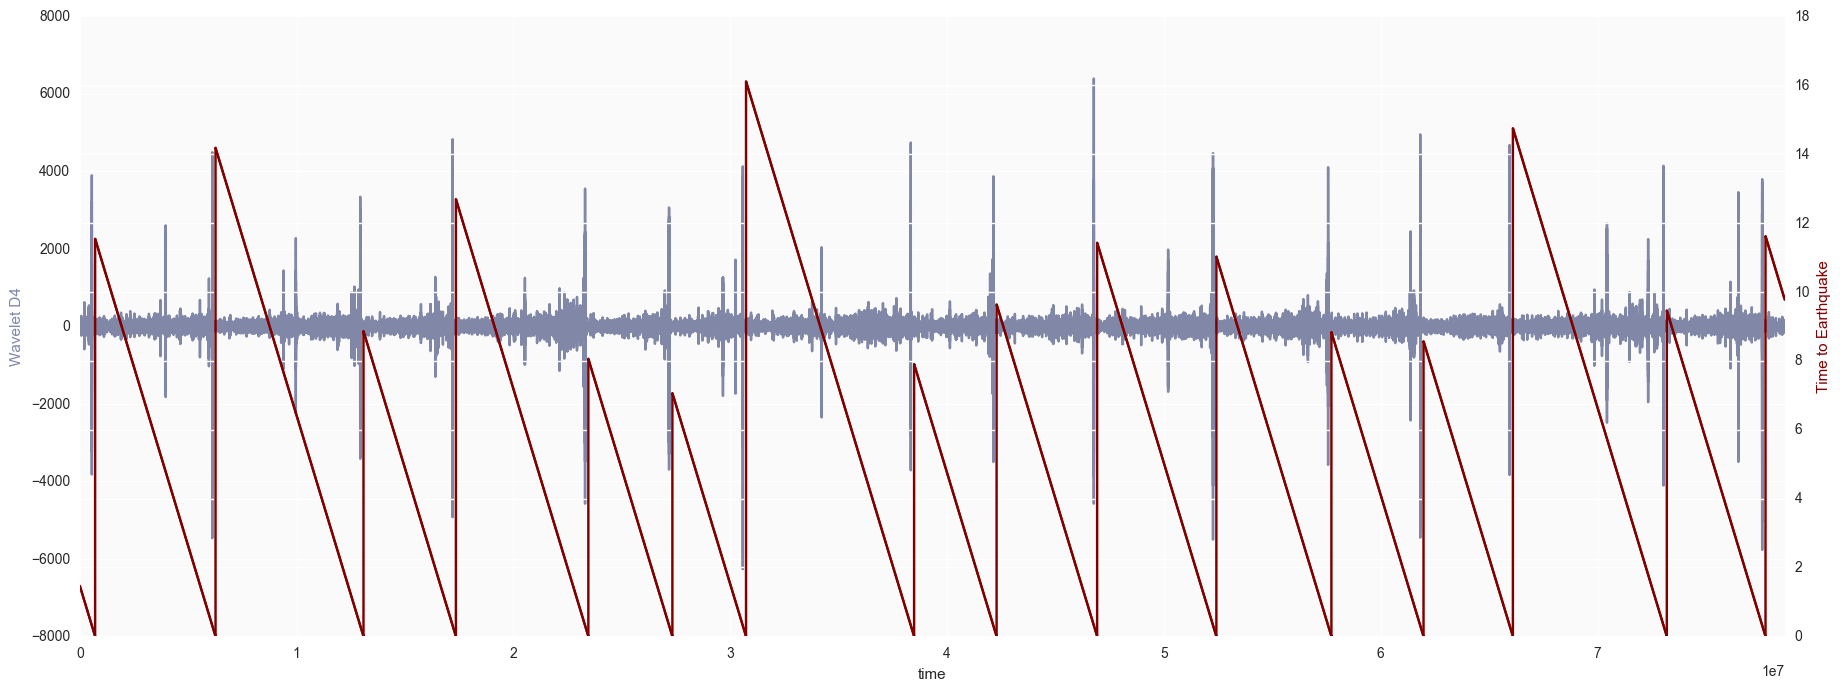

In [18]:
filepath = 'c:/Users/nely_/A_Projects/Python/ShakingEarth/Train/train'
dim = 150000
num_tr = 4194
seg_tr = pd.DataFrame(index=range(num_tr),columns=['median','mean'])
tim_tr = pd.DataFrame(index=range(num_tr),columns=['tim','max'])

bSIGNAL = False
bWAVELET = True
bMEAN = False
wname = 'haar'
numlevels = 4
if bWAVELET:
    if numlevels > 1:
        adim = pywt.dwt_coeff_len(dim, pywt.Wavelet(wname),mode='symmetric')
        for nlevel in range(2, numlevels):
            adim = pywt.dwt_coeff_len(adim, pywt.Wavelet(wname),mode='symmetric')
        print('Compressing dim=' +  str(dim) + ' into adim=' + str(adim))
    else:
        adim = dim


fig1 = plt.figure(figsize=(22, 8))
ax1 = plt.subplot(1,1,1)
ax2 = ax1.twinx()
mmin = 10000
mmax = -1
ia0 = 0
i0 = 0
for i in range(num_tr):
    if i % 500 == 0:
        print("train"+str(i+1).zfill(4))
    mat_container = sio.loadmat(filepath+str(i+1).zfill(4)+'.mat')
    seg = mat_container['seg'].flatten()
    tim = mat_container['tim'].flatten()
    seg_tr.iloc[i,0] = np.median(seg)
    seg_tr.iloc[i,1] = np.mean(seg)
    tim_tr.iloc[i,0] = tim[len(seg)-1]
    tim_tr.iloc[i,1] = np.max(tim)
    
    if bSIGNAL:
        indx = range(i0, i0+dim, 10)
        indy = range(0, dim, 10)
        line1 = ax1.plot(indx, seg[indy],color="#8087A7")
        line2 = ax2.plot(indx, tim[indy],color='#800000')
        
    if bWAVELET:
        (A, D) = pywt.dwt(seg.astype('float64'), wname)
        for nlevel in range(2, numlevels):
            (A, D) = pywt.dwt(A, wname)
            
        indx = range(ia0, ia0+adim)
        if numlevels > 1:
            indyt = range(0, dim, pow(2,numlevels-1))
            if len(indyt) > adim:
                indyt = indyt[1:]
        else:
            indyt = range(0, adim)
        line1 = ax1.plot(indx, A ,color="#8087A7")
        #line1 = ax1.plot(indx, D ,color="#8087A7")
        line2 = ax2.plot(indx, tim[indyt],color='#800000')
        
    if bMEAN:
        indx = range(i0, i0+dim, 10)
        indy = range(0, dim, 10)
        m = np.mean(seg)
        if mmin > m:
            mmin = m
        if mmax < m:
            mmax = m
        x = [i0,dim+i0]
        y = [m, m]
        line1 = ax1.plot(x, y, color="#8087A7", linewidth=8) 
        line2 = ax2.plot(indx, tim[indy],color='#800000')        
        
    i0 = i0 + dim  
    ia0 = ia0 + adim
    
ax1.set_xlim([0, max(indx)])
ax1.set_xlabel('time')
ax2.set_ylabel('Time to Earthquake', color='#800000')
ax1.patch.set_facecolor('#FAFAFA') 

if bSIGNAL:
    ax1.set_ylabel('Signal', color="#8087A7")
    fig1.savefig('c:/Users/nely_/A_Projects/Python/ShakingEarth/docs/plots/17_earthquakes.png')
if bWAVELET:
    ax1.set_ylabel('Wavelet A'+str(numlevels), color="#8087A7")    
    #ax1.set_ylabel('Wavelet D'+str(numlevels), color="#8087A7")    
    fig1.savefig('c:/Users/nely_/A_Projects/Python/ShakingEarth/docs/plots/17_earthquakes_'+wname+'_a'+str(numlevels)+'.png')
if bMEAN:
    ax1.set_ylim([3.5, 5.5])
    ax1.set_ylabel('Signal Mean'+str(numlevels), color="#8087A7")    
    fig1.savefig('c:/Users/nely_/A_Projects/Python/ShakingEarth/docs/plots/17_earthquakes_mean.png')
plt.show()

There are 17 earthquakes: 
    
- 0th earthquake has no data for the beginning, we don't know its total length
- 16th earthquake has no data for the ending
- 8 long earthquakes (1, 2, 4, 7, 10, 11, 14, 16) with max(Time to Earthquake) > 11
- 8 short length earthquakes (3, 5, 6, 8, 9, 12, 13, 15) with max(Time to Earthquake) < 11

Mean earthquake length = 10.73  
Median earthquake length = 10.33  
Each earthquake lasts for ~150,000 * 200 = 30,000,000 observations  

Short earthquakes look more uniform and are likely to share some features. 3rd and 12th are almost identical!! Long earthquakes seem to have more individuality. We might consider putting some of the earthquakes aside and training our models using data for those earthquakes that are close to test samples. 

## Average Earthquake

In [ ]:
import itertools

bZOOM = False
bCOLOR = True

bSIGNAL = True
bWAVELET = False

bTIME = False
bOUTLIERS = False
bSHANNON = False
bMFCC = True

filepath = 'c:/Users/nely_/A_Projects/Python/ShakingEarth/Train/'
dim = 150000
num_tr = 4194
seg_tr = pd.DataFrame(index=range(num_tr),columns=['a0_ou1','mean'])
tim_tr = pd.DataFrame(index=range(num_tr),columns=['tim','max'])

adim = dim
if bWAVELET:
    mat_container = sio.loadmat(filepath+'/train_4194/train_haar_a4.mat')
    A_tr = mat_container['A'].flatten()
    mat_container = sio.loadmat(filepath+'/train_4194/train_haar_T4.mat')
    T_tr = mat_container['T'].flatten()
    adim = 18750
if bOUTLIERS:
    d = pd.read_csv(filepath+'/train_4194/train_haar_a4_sta4194.csv')
    a4_ou1 = d["a4_ou1"]                           
if bSHANNON:
    d = pd.read_csv(filepath+'/train_4194/train_haar_d4_sta4194.csv')
    d4_sh = d["d4_sh"]                           
if bMFCC:
    d = pd.read_csv(filepath+'/train_4194/train_haar_a4_sta4194.csv')
    a4_mf0 = d["a4_mf0"]                           
                                

fig1 = plt.figure(figsize=(22, 8))
ax1 = plt.subplot(1,1,1)
ax2 = ax1.twinx()

max_factor = 10 # median earthquake length

max_hit = 0 
imax = 0
i0 = 0
ia0 = 0     

fold_n = -1
for i in range(0,4194):
    if i % 500 == 0:
        print("train"+str(i+1).zfill(4))
        
    indya = range(ia0, ia0+adim)
    
    if bSIGNAL:
        mat_container = sio.loadmat(filepath+"train"+str(i+1).zfill(4)+'.mat')
        seg = mat_container['seg']
        tim = mat_container['tim']
        amaxv = np.max(abs(seg))
        seg_tr.iloc[i,0] = count_peaks(seg,[1])[0]
        seg_tr.iloc[i,1] = np.mean(seg)
        tim_tr.iloc[i,0] = tim[len(seg)-1][0] # minimal time to earthquake
        tim_tr.iloc[i,1] = np.max(tim) # max time to earthquake
        tmax = tim_tr.iloc[i,1] # max
    if bWAVELET:
        tmax = np.max(T_tr[indya])
        
    #if i in (0,38,334,698,926,1251,1458,1639,2053,2256,2503,2796,3079,3306,3526,3904,4147):
    if i in (0,37,333,697,925,1250,1457,1638,2052,2255,2502,2795,3078,3305,3525,3903,4146):
        max_hit = tmax
        fold_color = "#F25059"
        if bCOLOR:
            #fold_color = plt.cm.coolwarm((tmax - 7.04) / 16.11)
            #fold_color = plt.cm.spectral((tmax - 7.04) / 16.11)
            fold_color = plt.cm.RdBu((tmax - 7.04) / 16.11)
        print(i0, max_hit, int(dim * max_factor / max_hit))
        fold_n = fold_n+1
        i0 = 0
        
    indx = range(i0, i0+dim, 10)
    indy = range(0, dim, 10)
    indxa = range(i0, i0+adim)
    
    if (fold_n > 0) & (fold_n < 16):
        # Plot 15 complete earthquakes only
        if bSIGNAL:
            line0 = ax1.plot(indx, seg[indy], color="#8087A7")
            t = min(tim[indy])[0]
            if bTIME:
                #line2 = ax2.plot(indx, tim[indy],color='#800000') # original 
                #line2 = ax2.plot(indx, tim[indy] / max_factor,color='#800000') # original / max_factor
                line2 = ax2.plot(indx, tim[indy] / max_hit,color='#800000') # original / max_hit
            if False:
                if i0 > 3.4e7: # find the very last peak
                    ind_hit = np.argmax(abs(seg)) 
                    if ind_hit.size > 0:
                        if np.isscalar(ind_hit):
                            ihit = ind_hit
                        else:
                            ihit = ind_hit[-1]
                        if seg[ihit][0] > 200:
                            print('Hit: file=', i+1, ' signal=', seg[ihit][0], ' time,original=', tim[ihit][0], ' time,normalized by max_hit=', tim[ihit][0] / max_hit)
                        #print(ind_hit[-1]+i0)
        if bWAVELET:
            line1 = ax1.plot(indxa, A_tr[indya], color="#8087A7")
            t = min(T_tr[indya])[0]
            if bTIME:
                line2 = ax2.plot(indxa, T_tr[indya],color='#800000') # original 
                #line2 = ax2.plot(indxa, T_tr[indya] / max_factor,color='#800000') # original / max_factor
                #line2 = ax2.plot(indxa, T_tr[indya] / max_hit,color='#800000') # original / max_hit
                
        if bCOLOR:
            fold_color = plt.cm.RdBu((t - 0) / 16.11)
        if bOUTLIERS:
            x = [i0,dim+i0]
            y = [a4_ou1[i], a4_ou1[i]]
            line3 = ax2.plot(x, y, color=fold_color, label='A4 Outliers', linewidth=2) 
        if bSHANNON:
            x = [i0,dim+i0]
            y = [d4_sh[i], d4_sh[i]]
            line4 = ax2.plot(x, y, color=fold_color, label='D4 Shannon', linewidth=2) 
        if bMFCC:
            x = [i0,dim+i0]
            y = [a4_mf0[i], a4_mf0[i]]
            line5 = ax2.plot(x, y, color=fold_color, label='D4 0th MFCC', linewidth=2) 
    
    if imax < i0 + dim:
        imax = i0 + dim
    i0 = i0 + int(dim * max_factor / max_hit)
    ia0 = ia0 + adim

if bZOOM:
    ax1.set_xlim([3.7e7, imax])
else:
    ax1.set_xlim([0, imax])
ax1.set_xlabel('time')
if bSIGNAL:
    ax1.set_ylabel('Signal', color="#8087A7")
if bWAVELET:
    ax1.set_ylabel('Wavelet A4', color="#8087A7")
    
if bTIME:
    ax2.set_ylabel('Time to Earthquake', color='#800000')
if bMFCC:
    ax2.set_ylabel('A4 0th MFCC', color="#8087A7")
if bSHANNON:
    ax2.set_ylabel('D4 Shannon', color="#8087A7")
if bOUTLIERS:
    ax2.set_ylabel('A4 Outliers', color="#8087A7")
    
ax1.grid(b=True, which='major', color='grey', linestyle='--')
ax1.patch.set_facecolor('#FAFAFA') 
fig1.savefig('c:/Users/nely_/A_Projects/Python/ShakingEarth/docs/plots/average_earthquake_normalized.png')
plt.show()

We see that signal peaks become more frequent as the time to earthquakes approaches 0. Signals with very small times (less than 3%) are measured AFTER the earthquake. It would be more correct if they we considered the beginning of the next earthquake and have times larger than the maximal time for the next earthquake.   

## Read train\*.mat and seg_\*.mat files, compute descriptors and save the to csv files

In [ ]:
def read_files_compute_statistics( filepath='train', num_tr=4194, fnames=[], dim=150000, wname='haar', numlevels=6):

    bAll = False
    
    if numlevels > 1:
        adim = pywt.dwt_coeff_len(dim, pywt.Wavelet(wname),mode='symmetric')
        for nlevel in range(2, numlevels):
            adim = pywt.dwt_coeff_len(adim, pywt.Wavelet(wname),mode='symmetric')
        print('Compressing dim=' +  str(dim) + ' into adim=' + str(adim))
    else:
        adim = dim

    fdim = int(dim/2)
    
    snumlevels = str(numlevels)
    snum_tr = str(num_tr)
    
    idx = generate_index(filepath=filepath+'_'+wname+'_i'+snumlevels+'_sta'+snum_tr+'.csv', num_tr=num_tr, dim=dim)
    
    bTrain = (len(fnames) == 0)
    seg_tr = pd.DataFrame(index=range(num_tr),columns=['median','mean','sum_abs','sum_sqr'])
    tim_tr = pd.DataFrame(index=range(num_tr),columns=['time','max'])

    bSave = (adim <= 150000/4)
    
    if (numlevels > 1) & (bSave):
        print("Preparing A, D, T arrays")
        A_tr = np.zeros(num_tr * adim)
        D_tr = np.zeros(num_tr * adim)        
        #F_tr = np.zeros(num_tr * (fdim+1))
        T_tr = np.zeros(num_tr * adim)   
    else: # dummy
        A_tr = np.zeros(1) 
        D_tr = np.zeros(1)        
        #F_tr = np.zeros(1)
        T_tr = np.zeros(1)   
        
    L1_tr = np.zeros(num_tr)
    L2_tr = np.zeros(num_tr)

    dummy, snames = compute_statistics([],[],0,0,bin_edges=[-10000,-100,-10,0,10,20,50,100,500,10000], dim=150000, bAll=bAll)
    staA_tr = pd.DataFrame(index=range(num_tr),columns=['a'+str(numlevels)+'_'+s for s in snames])
    staD_tr = pd.DataFrame(index=range(num_tr),columns=['d'+str(numlevels)+'_'+s for s in snames])
        
    dummy, snames = compute_statistics([],[],0,0,bin_edges=[0,1./128,1./64,1./32,1./16,1./8,1./4,1./2,1.], dim=150000, bAll=bAll)
    staF_tr = pd.DataFrame(index=range(num_tr),columns=['f'+str(numlevels)+'_'+s for s in snames])
    
    fig1 = plt.figure(figsize=(22, 8))
    ax1 = plt.subplot(1,1,1)
    ax2 = ax1.twinx()

    i0 = 0
    ia0 = 0
    if0 = 0
    imax0 = 0
    for i in range(num_tr):
        if i % 500 == 0:
            print("file"+str(i+1).zfill(4))
        if bTrain:
            mat_container = sio.loadmat(filepath+str(i+1).zfill(4)+'.mat')
            seg = mat_container['seg'].flatten()
            tim = mat_container['tim'].flatten()
        else:
            mat_container = sio.loadmat(filepath+fnames[i]+'.mat')
            seg = mat_container['seg'].flatten()
            
        seg_tr.iloc[i,0] = np.median(seg)
        seg_tr.iloc[i,1] = np.mean(seg)
        seg_tr.iloc[i,2] = np.sum(np.abs(seg))
        seg_tr.iloc[i,3] = np.sum(np.square(seg))
        if bTrain:
            tim_tr.iloc[i,0] = tim[len(seg)-1]
            tim_tr.iloc[i,1] = np.max(tim)
                        
        indxa = range(ia0, ia0+adim)
        indya = range(0, adim)
        indxt = range(ia0, ia0+adim)
        if numlevels > 1:
            indyt = range(0, dim, pow(2,numlevels-1))
            #adim = int(dim / pow(2,numlevels-1)) # rough estimate, can be different from adim=dwt_coeff_len 
            if len(indyt) > adim:
                indyt = indyt[1:]
        else:
            indyt = range(0, adim)
        
        l1 = np.sum(np.abs(seg))
        l2 = np.sum(np.square(seg))

        if numlevels > 1:                
            # Wavelets
            A, D = pywt.dwt(seg.astype('float64'), wname)
            for nlevel in range(2, numlevels):
                A, D = pywt.dwt(A, wname)

            staA_tr.iloc[i,:] = compute_statistics(staA_tr.iloc[i,:], A, l1, l2,
                                    bin_edges=[-10000,-100,-10,0,10,20,50,100,500,10000], dim=150000, bAll=bAll)
            staD_tr.iloc[i,:] = compute_statistics(staD_tr.iloc[i,:], D, l1, l2,
                                    bin_edges=[-10000,-100,-10,0,10,20,50,100,500,10000], dim=150000, bAll=bAll) 
            if bSave:
                A_tr[indxa] = A            
                D_tr[indxa] = D
                if bTrain:
                    T_tr[indxa] = tim[indyt].flatten()
        else:
            A = seg
            staA_tr.iloc[i,:] = compute_statistics(staA_tr.iloc[i,:], seg, l1, l2,
                                    bin_edges=[-10000,-100,-10,0,10,20,50,100,500,10000], dim=150000, bAll=bAll)

        # FFT of original signal or of A (=wavelet approximation of the signal)
        F = np.abs(np.fft.rfft(seg.astype(float).flatten()) / dim)[1:].flatten()
        F[1:] = 2 * F[1:]
        staF_tr.iloc[i,:] = compute_statistics(staF_tr.iloc[i,:], F, seg_tr.iloc[i,2], seg_tr.iloc[i,3], 
                                bin_edges=[0,1./128,1./64,1./32,1./16,1./8,1./4,1./2,1.], dim=150000, bAll=bAll)
        #F_tr[indxf] = F

        L1_tr[i] = l1 # approximate with L1 for seg[indp]
        L2_tr[i] = l2 # approximate with L2 for seg[indp]
        
        ax1.plot(indxt, A,color="#8087A7")
        if bTrain:
            ax2.plot(indxt, tim[indyt],color='#800000')

        imax0 = ia0 + adim
        i0 = i0 + dim
        ia0 = ia0 + adim
        if0 = if0 + fdim            
            
    if (numlevels > 1) & (bSave):
        print("Saving A, D (and T) to mat files")
        sio.savemat(filepath+'_'+wname+'_a'+snumlevels+'.mat', {'A':A_tr})    
        sio.savemat(filepath+'_'+wname+'_d'+snumlevels+'.mat', {'D':D_tr})    
        #sio.savemat(filepath+'_'+wname+'_f'+snumlevels+'.mat', {'F':F_tr})    
        if bTrain:
            sio.savemat(filepath+'_'+wname+'_T'+snumlevels+'.mat', {'T':T_tr})  
                
    print("Saving L1, L2 to mat files")
    sio.savemat(filepath+'_'+wname+'_a'+snumlevels+'_l1.mat', {'L1':L1_tr})    
    sio.savemat(filepath+'_'+wname+'_a'+snumlevels+'_l2.mat', {'L2':L2_tr})    
        
    print("Saving A, D, F statistics (and time) to csv files")
    staA_tr.to_csv(filepath+'_'+wname+'_a'+snumlevels+'_sta'+snum_tr+'.csv',index=False)
    staD_tr.to_csv(filepath+'_'+wname+'_d'+snumlevels+'_sta'+snum_tr+'.csv',index=False)
    staF_tr.to_csv(filepath+'_'+wname+'_f'+snumlevels+'_sta'+snum_tr+'.csv',index=False)
    if bTrain:
        tim_tr.to_csv(filepath+'_'+wname+'_T'+snumlevels+'_sta'+snum_tr+'.csv')
    
    if bTrain:
        print("Computing A, D correlations with time and saving to csv files") 
        compute_correlations(tim_tr["time"].values, staA_tr, filepath+'_'+wname+'_a'+snumlevels+'_cor'+snum_tr+'.csv')
        compute_correlations(tim_tr["time"].values, staD_tr, filepath+'_'+wname+'_d'+snumlevels+'_cor'+snum_tr+'.csv')
        compute_correlations(tim_tr["time"].values, staF_tr, filepath+'_'+wname+'_f'+snumlevels+'_cor'+snum_tr+'.csv')
    
    ax1.set_xlim([0, imax0])
    ax1.set_xlabel('time')
    if numlevels > 1: 
        ax1.set_ylabel('Wavelet A'+snumlevels, color="#8087A7")
    else:
        ax1.set_ylabel('Signal', color="#8087A7")
    if bTrain:
        ax2.set_ylabel('Time to Earthquake', color='#800000')
    ax1.grid(b=True, which='major', color='grey', linestyle='--')
    plt.show()
    
    return A_tr, D_tr, T_tr, staA_tr, staD_tr, staF_tr, tim_tr, seg_tr, adim

In [ ]:
# Training
A_tr, D_tr, T_tr, staA_tr, staD_tr, staF_tr, tim_tr, seg_tr, adim = read_files_compute_statistics( 
    filepath='c:/Users/nely_/A_Projects/Python/ShakingEarth/Train/train', 
    num_tr=4194, fnames = [], dim=150000, wname='haar', numlevels=4)

In [ ]:
# TEST
fnames_TE = pd.read_csv('c:/Users/nely_/A_Projects/Python/ShakingEarth/Test/sample_submission.csv')
fnames_TE.columns = ['seg_id', 'num_id']
fnames_TE = fnames_TE.replace('seg_', '', regex=True)

A_TE, D_TE, T_TE, staA_TE, staD_TE, staF_TE, tim_TE, seg_TE, adim = read_files_compute_statistics( 
    filepath='c:/Users/nely_/A_Projects/Python/ShakingEarth/Test/seg_', 
    num_tr=2624, fnames=fnames_TE['seg_id'].tolist(), dim=150000, wname='haar', numlevels=4)

## Generate Plots for PPT and PDF

In [ ]:
plt.figure(figsize=(22, 8))
ax1 = plt.subplot(1,1,1)
ax1.plot(staD_tr['le'], color='#8087A7')
ax1.set_xlim([0, num_tr])
ax1.patch.set_facecolor('#FAFAFA') 
plt.title('D6_le')

In [ ]:
mat_container = sio.loadmat('c:/Users/nely_/A_Projects/Python/ShakingEarth/Train/train0001.mat')
seg = mat_container['seg']
print(seg.shape)
tim = mat_container['tim']
print(tim.shape)

fig1 = plt.figure(figsize=(22, 8))
ax1 = plt.subplot(1,1,1)
ax1.plot(seg, color='#8087A7')
ax1.set_xlim([0, 150000])
ax1.patch.set_facecolor('#FAFAFA') 
plt.title('Signal of length 150,000')
fig1.savefig('c:/Users/nely_/A_Projects/Python/ShakingEarth/docs/plots/signal_150000.png')

numlevels = 4
A, D = pywt.dwt(seg.astype('float64'), wname)
for nlevel in range(2, numlevels):
    A, D = pywt.dwt(A, wname)

plt.figure(figsize=(22, 8))
ax1 = plt.subplot(1,1,1)
ax1.plot(A_tr[0:adim], color='#8087A7')
ax1.set_xlim([0, adim])
ax1.patch.set_facecolor('#FAFAFA') 
ax1.grid(b=True, which='major', color='grey', linestyle='--')
plt.title('Wavelet A'+str(numlevels))
fig1.savefig('c:/Users/nely_/A_Projects/Python/ShakingEarth/docs/plots/wavelet'+str(numlevels)'.png')

Plot normalized time and signal for earthquakes 1...15 in one plot

In [ ]:
d = np.argwhere(np.diff(T_tr)>1)
df = pd.DataFrame({'Fold':range(1,17),'LastPre':range(16),'First':range(16),'Tmax':range(16),'FileID':range(16)})
df = df.set_index('Fold')
df.reset_index(inplace=True)
df['LastPre'] = d
df['First'] = d+1
df['Tmax'] = T_tr[d+1]
df['FileID'] = ((d+1)/adim).astype(int)
df

max_factor = df['Tmax'].max()

plt.figure(figsize=(22, 8))
ax1 = plt.subplot(1,1,1)
ax2 = ax1.twinx()
xmax = 0
for nfold in range(1,16):
    max_hit = df['Tmax'][nfold-1]
    print(max_hit)
    i1 = df['First'][nfold-1]
    i2 = df['First'][nfold]-1
    istep = int(adim * max_factor / max_hit)
    print(istep)
    i0 = 0
    j1 = int(i1/adim)
    j2 = int((i2+1)/adim)-1
    for j in range(j1,j2):
        indx0 = range(i0, i0+adim)
        indy0 = range(i1+(j-j1)*adim, i1+(j-j1+1)*adim) 
        ax1.plot(indx0, A_tr[indy0], color='#8087A7')
        ax2.plot(indx0, T_tr[indy0] / max_hit, color='#800000')  
        if xmax < i0+adim:
            xmax = i0+adim
        i0 = i0 + istep  
    if False: # no normalization
        indx = range(i2-i1)
        ax1.plot(indx, A_tr[i1:i2], color='#8087A7')    
        #ax2.plot(indx, T_tr[i1:i2] / max_factor, color='#800000')     
        ax2.plot(indx, T_tr[i1:i2] / max_hit, color='#800000')   
ax1.set_xlim([0, xmax])
ax2.patch.set_facecolor('#FAFAFA') 
ax2.grid(b=True, which='major', color='grey', linestyle='--')
plt.title('Earthquakes 1...15. Wavelet A'+str(numlevels)+' and Normalized Time to Earthquake')
plt.show()

Plot signal mean 

In [ ]:
plt.figure(figsize=(22, 8))
ax1 = plt.subplot(1,1,1)
#ax1.scatter(range(num_tr), tim_tr['max'])
ax1.scatter(range(0,num_tr*dim,dim), seg_tr['mean'], color="#8087A7")
ax2 = ax1.twinx()
ax2.plot(range(0,num_tr*dim,dim), tim_tr['tim'],color='#800000')
ax1.set_xlim([0, num_tr*dim])
ax1.set_xlabel('time')
ax1.set_ylabel('Signal Mean', color="#8087A7")
ax2.set_ylabel('Time to Earthquake', color='#800000')
plt.show()

Read and plot TEST data

In [ ]:
filepath = 'c:/Users/nely_/A_Projects/Python/ShakingEarth/Test/'
fnames_te = pd.read_csv(filepath+'sample_submission.csv')
fnames_te.columns = ['seg_id', 'num_id']
dim = 150000
num_te = fnames_te.shape[0]
seg_te = pd.DataFrame(index=range(num_te),columns=['median','mean'])
fig1 = plt.figure(figsize=(22, 8))
ax1 = plt.subplot(1,1,1)
i0 = 0
for i in range(2): #num_te):
    if i % 500 == 0:
        print("test"+str(i+1).zfill(4))
    fname = fnames_te.iloc[i,0]
    mat_container = sio.loadmat(filepath+fname+'.mat')
    seg = mat_container['seg']
    seg_te.iloc[i,0] = np.median(seg)
    seg_te.iloc[i,1] = np.mean(seg)
    fnames_te.iloc[i,1] = int(fname[4:], 16)
    
    i0 = int(fname[4:], 16) # they overlap?
    indx = range(i0, len(seg)+i0, 10)
    indy = range(0, len(seg), 10)
    line1 = ax1.plot(indx, seg[indy]) #,color="#8087A7")
    #i0 = i0 + dim  
ax1.set_xlim([0, max(indx)])
ax1.set_xlabel('time')
ax1.set_ylabel('Signal', color="#8087A7")
plt.show()

## Read mat files, compute descriptors and save to csv files

In [37]:
def read_mat_compute_descriptors( filepath='train', num_tr=4194, dim=150000, wname='haar', numlevels=6, idx_tr=[]):   

    snumlevels = str(numlevels)
    
    adim = pywt.dwt_coeff_len(dim, pywt.Wavelet(wname),mode='symmetric')
    for nlevel in range(2, numlevels):
        adim = pywt.dwt_coeff_len(adim, pywt.Wavelet(wname),mode='symmetric')
    print("Compressing dim=150,000 into adim=",adim)
    
    if len(idx_tr) == 0:
        idx_tr = generate_index(filepath=filepath+'_'+wname+'_i'+snumlevels+'_sta'+str(num_tr)+'.csv', num_tr=num_tr, dim=dim)
        print(idx_tr.shape)
        print(idx_tr[1:10])
        astep_tr = int(np.floor((4194.0-1) * adim / (num_tr-1)))
        print("adim="+str(adim))
        print("astep_tr="+str(astep_tr))
    else:
        num_tr = len(idx_tr)
        idx_tr = np.array(idx_tr)
        idx_tr = np.sort(idx_tr)
        print(idx_tr.shape)
    snum_tr = str(num_tr)
    
    print("Saving index to csv file")
    idx_df = pd.DataFrame(idx_tr,columns=['id'])
    idx_df.to_csv(filepath+'_'+wname+'_i'+snumlevels+'_sta'+snum_tr+'.csv',index=False)
   
    dummy, snames = compute_statistics([],[],0,0, bin_edges=[-10000,-100,-10,0,10,20,50,100,500,10000], dim=150000, bAll=False)
    staS_tr = pd.DataFrame(index=range(num_tr),columns=['s'+str(numlevels)+'_'+s for s in snames])    
    staA_tr = pd.DataFrame(index=range(num_tr),columns=['a'+str(numlevels)+'_'+s for s in snames])    
    staD_tr = pd.DataFrame(index=range(num_tr),columns=['d'+str(numlevels)+'_'+s for s in snames])
    
    tim_tr = pd.DataFrame(index=range(num_tr),columns=["time"])
    
    idx_file0 = np.floor(idx_tr / dim).astype(int) # file
    idx_id0 = (idx_tr % dim).astype(int) # element in file
    
    ifile0 = -1
    for i in range(num_tr):        
        # Read idx_file0 and next with seg starting from i and ending i+dim-1 inclusive
        if (ifile0 != idx_file0[i]):
            ifile0 = idx_file0[i]
            
            if ifile0+1 > 4194:
                print("file0+1=",ifile0+1)
                break;            
            mat_container = sio.loadmat(filepath+str(ifile0+1).zfill(4)+'.mat')
            seg0 = mat_container['seg'].flatten()
            tim0 = mat_container['tim'].flatten()
            
            if ifile0+2 > 4195:
                print("file0+2=",ifile0+2)
                break;            
            mat_container = sio.loadmat(filepath+str(ifile0+2).zfill(4)+'.mat')
            seg1 = mat_container['seg'].flatten()
            tim1 = mat_container['tim'].flatten()
            
            seg01 = np.concatenate((seg0, seg1), axis=None)
            tim01 = np.concatenate((tim0, tim1), axis=None)
        
        if idx_id0[i] >= seg01.shape[0]:
            print("idx_id0[i] >= seg01.shape[0]")
            break
        if idx_id0[i]+dim >= seg01.shape[0]:
            print("idx_id0[i]+dim >= seg01.shape[0]")
            break
        seg = seg01[idx_id0[i]:(idx_id0[i]+dim)]
        tim = tim01[idx_id0[i]:(idx_id0[i]+dim)]
        
        if i % 500 == 0:
            print("fragment"+str(i+1).zfill(4)+" file="+str(ifile0+1).zfill(4))
        if i % 10000 == 0:
            print("Saving A, D, T to tmp parquet files")
            pq.write_table(pa.Table.from_pandas(staS_tr), filepath+'_'+wname+'_s'+snumlevels+'_sta'+snum_tr+'.parquet')
            pq.write_table(pa.Table.from_pandas(staA_tr), filepath+'_'+wname+'_a'+snumlevels+'_sta'+snum_tr+'.parquet')
            pq.write_table(pa.Table.from_pandas(staD_tr), filepath+'_'+wname+'_d'+snumlevels+'_sta'+snum_tr+'.parquet')
            pq.write_table(pa.Table.from_pandas(tim_tr), filepath+'_'+wname+'_T'+snumlevels+'_sta'+snum_tr+'.parquet')
        
        A, D = pywt.dwt(seg.astype('float64'), wname)
        for nlevel in range(2, numlevels):
            A, D = pywt.dwt(A, wname)
                        
        l1 = np.sum(np.abs(seg))
        l2 = np.sum(np.square(seg))
            
        #staS_tr.iloc[i,:] = compute_statistics(staS_tr.iloc[i,:], seg, l1, l2, 
        #                        bin_edges=[-10000,-100,-10,0,10,20,50,100,500,10000], dim=150000, bAll=False)
        staA_tr.iloc[i,:] = compute_statistics(staA_tr.iloc[i,:], A, l1, l2, 
                                bin_edges=[-10000,-100,-10,0,10,20,50,100,500,10000], dim=150000, bAll=False)
        staD_tr.iloc[i,:] = compute_statistics(staD_tr.iloc[i,:], D, l1, l2,
                                bin_edges=[-10000,-100,-10,0,10,20,50,100,500,10000], dim=150000, bAll=False)   

        tim_tr.iloc[i,0] = tim[-1]
 
    print("Saving S, A, D descriptors and time to csv files")
    staS_tr.to_csv(filepath+'_'+wname+'_s'+snumlevels+'_sta'+snum_tr+'.csv',index=False)
    staA_tr.to_csv(filepath+'_'+wname+'_a'+snumlevels+'_sta'+snum_tr+'.csv',index=False)
    staD_tr.to_csv(filepath+'_'+wname+'_d'+snumlevels+'_sta'+snum_tr+'.csv',index=False)
    tim_tr.to_csv(filepath+'_'+wname+'_T'+snumlevels+'_sta'+snum_tr+'.csv',index=False)
        
    print("Computing A, D correlations with time and saving to csv files") 
    #compute_correlations(tim_tr["time"].values, staS_tr, filepath+'_'+wname+'_s'+snumlevels+'_cor'+snum_tr+'.csv')
    compute_correlations(tim_tr["time"].values, staA_tr, filepath+'_'+wname+'_a'+snumlevels+'_cor'+snum_tr+'.csv')
    compute_correlations(tim_tr["time"].values, staD_tr, filepath+'_'+wname+'_d'+snumlevels+'_cor'+snum_tr+'.csv')
        
    print("Saving A, D statistics (and time) to parquet files")
    pq.write_table(pa.Table.from_pandas(staS_tr), filepath+'_'+wname+'_s'+snumlevels+'_sta'+snum_tr+'.parquet')
    pq.write_table(pa.Table.from_pandas(staA_tr), filepath+'_'+wname+'_a'+snumlevels+'_sta'+snum_tr+'.parquet')
    pq.write_table(pa.Table.from_pandas(staD_tr), filepath+'_'+wname+'_d'+snumlevels+'_sta'+snum_tr+'.parquet')
    pq.write_table(pa.Table.from_pandas(tim_tr), filepath+'_'+wname+'_T'+snumlevels+'_sta'+snum_tr+'.parquet')
        
    #tim_tr = correct_time(idx_df, tim_tr)

    print("Saving folds to csv")
    prepare_folds(tim_tr, filepath+'_'+wname+'_a'+str(numlevels)+'_folds_'+str(num_tr)+'.csv')
    
    return staA_tr, staD_tr, tim_tr

In [ ]:
if False:
    filepath = 'c:/Users/nely_/A_Projects/Python/ShakingEarth/model20190824/model20190824_227800_i_tr.csv'
    idx = pd.read_csv(filepath).values.flatten()
    mask = pd.read_csv(filepath.replace("_i", "_u")).values.astype(bool).flatten()
    idx = idx[mask]
    print(idx[0:10])

    staA_train, staD_train, staT_train = read_mat_compute_descriptors( 
        filepath='c:/Users/nely_/A_Projects/Python/ShakingEarth/Train/train', 
        num_tr=idx.shape[0], dim=150000, wname='haar', numlevels=4, idx_tr=idx)

In [ ]:
a = pd.read_csv('c:/Users/nely_/A_Projects/Python/ShakingEarth/Train/train_sta_10000/train_haar_a4_sta10000.csv')
d = pd.read_csv('c:/Users/nely_/A_Projects/Python/ShakingEarth/Train/train_sta_10000/train_haar_d4_sta10000.csv')
#x = pd.concat([d['d4_hi4'],d['d4_le'],d['d4_sh'],d['d4_hi1'],a['a4_sh'],d['d4_hi3'],d['d4_mf0'],a['a4_mf0'],d['d4_hi2']], axis=1)
x = pd.concat([d['d4_hi4'],d['d4_sh'],d['d4_mf2'],d['d4_mf1'],a['a4_mf11'],a['a4_ou1']], axis=1)

corr = x.corr()
print(corr)

sns_plot = sns.heatmap(corr, 
            #xticklabels=corr.columns.values,
            #yticklabels=corr.columns.values,
            cmap="OrRd")
sns_plot.get_figure().savefig('c:/Users/nely_/A_Projects/Python/ShakingEarth/docs/plots/inputs_heatmap.png')

In [ ]:
a = pd.read_csv('c:/Users/nely_/A_Projects/Python/ShakingEarth/Train/train_sta_10000/train_haar_a4_sta10000.csv')
d = pd.read_csv('c:/Users/nely_/A_Projects/Python/ShakingEarth/Train/train_sta_10000/train_haar_d4_sta10000.csv')
x = pd.concat([a,d], axis=1)
print(x.head())

ac = pd.read_csv('c:/Users/nely_/A_Projects/Python/ShakingEarth/Train/train_sta_10000/train_haar_a4_cor10000.csv')
dc = pd.read_csv('c:/Users/nely_/A_Projects/Python/ShakingEarth/Train/train_sta_10000/train_haar_d4_cor10000.csv')
xc = pd.concat([ac,dc], axis=1)

In [ ]:
isort = (-xc.loc[1].abs()).argsort()
xc_sorted = xc[isort].reset_index(drop=True)
x_sorted = x[isort].reset_index(drop=True)
print(x_sorted.head())

corr_sorted = x_sorted.corr()

gr = list()
for i in range(xc.shape[1]):
    if corr_sorted.shape[1] == 0:
        break
    mask = (abs(corr_sorted.iloc[0,:]) > 0.98).values
    print("group leader=", xc_sorted.columns[0], 
          " spearman_out=", xc_sorted.iloc[1,0], 
          " pearson_out=", xc_sorted.iloc[0,0], 
          " size=", sum(mask))
    #print(corr_sorted.iloc[0,mask])
    #print(xc_sorted.loc[:,mask])
    drop_list = list(xc_sorted.columns[mask])
    print(drop_list)
    gr.append(drop_list)
    xc_sorted = xc_sorted.drop(drop_list, axis=1)
    corr_sorted = corr_sorted.drop(drop_list, axis=1)
    corr_sorted = corr_sorted.drop(drop_list, axis=0)
    #print(corr_sorted)
    

## Merge datasets

In [29]:
import os.path
from os import path

def correct_time(idx, ti):
    dim = 150000
    num_tr = 4194
    
    idx.id = idx.id + dim - 1 
    
    idx_file = np.floor(idx.id.values / dim).astype(int) # file
    idx_id0 = (idx.id.values % dim).astype(int) # element in file
        
    filepath0 = 'c:/Users/nely_/A_Projects/Python/ShakingEarth/Train/train'
    for i in range(num_tr):
        if i % 500 == 0:
            print("file"+str(i+1).zfill(4))
        mat_container = sio.loadmat(filepath0+str(i+1).zfill(4)+'.mat')
        tim = mat_container['tim'].flatten()  
        
        ind, = np.where(idx_file == i)
        ti.time.iloc[ind] = tim[ idx_id0[ind] ]
        
    return ti

def merge_datasets(filepath1='c:/Users/nely_/A_Projects/Python/ShakingEarth/Train/train_100100/train_haar_a4_sta100100.csv', 
                   filepath2='c:/Users/nely_/A_Projects/Python/ShakingEarth/Train/train_50000/train_haar_a4_sta50000.csv', 
                   filepath_csv='c:/Users/nely_/A_Projects/Python/ShakingEarth/Train/train_150100/train_haar_a4_sta150100.csv', 
                   column_names=['d4_hi4','d4_sh','d4_mf2','d4_mf1','a4_mf11','a4_ou1']):
    
    fid = list()
    fad = list()
    fti = list()
    ftm = list()
    for filepath in [filepath1, filepath2]:
        if filepath == "":
            continue
            
        # Load index, time, descriptors for 2 datasets
        if path.exists(filepath):
            a1 = pd.read_csv(filepath)    
            d1 = pd.read_csv(filepath.replace("haar_a", "haar_d"))
            ad1 = pd.concat([a1,d1], axis=1)
            f1 =  pd.read_csv(filepath.replace("_sta", "_folds_"))
        else:
            ad1 = pd.read_csv(filepath.replace("haar_a", "haar_AD"))
            f1 =  pd.read_csv(filepath.replace("haar_a", "haar_AD").replace("_sta", "_folds_"))
        ti1 = pd.read_csv(filepath.replace("haar_a", "haar_T"))
        idx1 = pd.read_csv(filepath.replace("haar_a", "haar_i"))
        
        if len(column_names) > 0:
            # Drop columns not in the list
            drop_list = list()
            for col in ad1.columns:
                if col not in column_names:
                    drop_list.append(col)
            ad1 = ad1.drop(drop_list, axis=1)
            ad1 = ad1[column_names]
            print(ad1.head())
        
        # Merge each fold separately
        for fold_n in range(17):
            i1 = f1.iloc[fold_n][1].astype(int)
            i2 = f1.iloc[fold_n][2].astype(int)
            ind = range(i1,i2+1)
            print("fold_n=",fold_n," i1=",i1," i2=",i2)
            
            tmax = ti1.iloc[ind]
            tmax["time"] = f1.iloc[fold_n][3]
            
            if filepath == filepath1:
                fid.append(idx1.iloc[ind])  
                fad.append(ad1.iloc[ind,:])
                fti.append(ti1.iloc[ind])
                ftm.append(tmax)
            else:
                # Merge
                fid[fold_n] = pd.concat([fid[fold_n], idx1.iloc[ind]]).reset_index(drop=True)
                fad[fold_n] = pd.concat([fad[fold_n], ad1.iloc[ind,:]]).reset_index(drop=True)
                fti[fold_n] = pd.concat([fti[fold_n], ti1.iloc[ind]]).reset_index(drop=True)
                ftm[fold_n] = pd.concat([ftm[fold_n], tmax]).reset_index(drop=True)
        
                # Sort with respect to index, drop duplicated indeces
                dummy, isort = np.unique(fid[fold_n]["id"].values, return_index=True)
                fid[fold_n] = fid[fold_n].iloc[isort].reset_index(drop=True)
                fad[fold_n] = fad[fold_n].iloc[isort].reset_index(drop=True)
                fti[fold_n] = fti[fold_n].iloc[isort].reset_index(drop=True) 
                ftm[fold_n] = ftm[fold_n].iloc[isort].reset_index(drop=True) 
                
    # Merge folds
    idx = fid[0]
    ad = fad[0]
    ti = fti[0]
    tm = ftm[0]
    for fold_n in range(1,17):
        idx = pd.concat([idx, fid[fold_n]])
        ad = pd.concat([ad, fad[fold_n]])
        ti = pd.concat([ti, fti[fold_n]])
        tm = pd.concat([tm, fti[fold_n]])
        
    # Sort again with respect to index, drop duplicated indeces
    isort = np.argsort(idx.values.flatten())
    idx = idx.iloc[isort].reset_index(drop=True)
    ad = ad.iloc[isort].reset_index(drop=True)
    ti = ti.iloc[isort].reset_index(drop=True) 
    tm = tm.iloc[isort].reset_index(drop=True) 
    
    ti = correct_time(idx, ti)
        
    print("Computing correlations with time and saving them to csv files") 
    compute_correlations(ti["time"].values, ad, filepath_csv.replace("haar_a", "haar_AD").replace("_sta", "_cor"))

    print("Computing correlations with Tmax and saving them to csv files") 
    compute_correlations(tm["time"].values, ad, filepath_csv.replace("haar_a", "haar_AD").replace("_sta", "_cortmax"))

    # Save new index, time, descriptors to files
    print("Saving to csv files")
    ad.to_csv(filepath_csv.replace("haar_a", "haar_AD"),index=False)
    idx.to_csv(filepath_csv.replace("haar_a", "haar_i"),index=False)
    ti.to_csv(filepath_csv.replace("haar_a", "haar_T"),index=False)
    tm.to_csv(filepath_csv.replace("haar_a", "haar_Tmax"),index=False)
                
    print("Saving to parquet files")
    filepath_parquet = filepath_csv.replace(".csv", ".parquet")
    pq.write_table(pa.Table.from_pandas(ad), filepath_parquet.replace("haar_a", "haar_AD"))
    pq.write_table(pa.Table.from_pandas(idx), filepath_parquet.replace("haar_a", "haar_i"))
    pq.write_table(pa.Table.from_pandas(ti), filepath_parquet.replace("haar_a", "haar_T"))    
    pq.write_table(pa.Table.from_pandas(ti), filepath_parquet.replace("haar_a", "haar_Tmax"))    
    #Reading parquet:
    #ti2 = pq.read_table(filepath_parquet.replace("haar_a", "haar_T")).to_pandas()
    
    print("Preparing folds and saving them to csv file") 
    prepare_folds(ti, filepath_csv.replace("haar_a", "haar_AD").replace("_sta", "_folds_"))
        
    return idx,ti, ad

In [ ]:
if False:
    filepath = 'c:/Users/nely_/A_Projects/Python/ShakingEarth/Train/train_227800/train_haar_T4_sta227800.csv'
    ti = pd.read_csv(filepath)
    prepare_folds(ti, filepath.replace("haar_T", "haar_AD").replace("_sta", "_folds_"))

In [ ]:
if False:
    idx, ti, ad = merge_datasets(filepath1='c:/Users/nely_/A_Projects/Python/ShakingEarth/Train/train_150100/train_haar_a4_sta150100.csv', 
                   filepath2='c:/Users/nely_/A_Projects/Python/ShakingEarth/Train/train_77700/train_haar_a4_sta77700.csv', 
                   filepath_csv='c:/Users/nely_/A_Projects/Python/ShakingEarth/Train/train_227800/train_haar_a4_sta227800.csv', 
                   column_names=['d4_hi4','d4_sh','d4_mf2','d4_mf1','a4_mf11','a4_ou1'])

In [ ]:
if False:
    num_tr = 4194
    dim = 150000
    filepath= 'c:/Users/nely_/A_Projects/Python/ShakingEarth/Train/train_4194/train'
    idx = generate_index(filepath=filepath+'_haar_i4_sta'+str(num_tr)+'.csv', num_tr=num_tr, dim=dim)

In [28]:
import random
import bisect

def search_bisect(k, idx_stop):
    ik = bisect.bisect_left(idx_stop, k)
    if (ik < 0) | (ik >= len(idx_stop)):
        return -1     
    else: 
        if (idx_stop[ik] != k):
            return -1
    return ik

def left_right(i0, idx, num, jmax):
    
    stop_list = list()
    
    num0 = num * 20
    num1 = num * 10
    j1 = max(0, idx[i0]-num0)
    if i0 > 0:
        j1 = min(jmax, idx[i0-1]+1)
        
    j2 = min(jmax, idx[i0]+num0)
    if i0 < idx.shape[0]:
        j2 = idx[i0+1]
        if (j2 > jmax) | (j2-j1 <= num1):
            j2 = min(jmax, idx[i0]+num0)            
    if j1 >= j2:
        print("Warning in left_right: i0=",i0," idx[i0]=",idx[i0],"j1=",j1," j2=",j2,"...Correcting to j1=",max(0, j2-num0))
        j1 = max(0, j2-num0)
        stop_list.append(idx[i0])
        return j1, j2, np.array(stop_list)
        
    for i in range(i0-1, 0,-1):
        if (idx[i] >= j1) & (idx[i] < j2):
            stop_list.append(idx[i])
        if (idx[i] < j1):
            break;          
    for i in range(i0, idx.shape[0]):
        if (idx[i] >= j1) & (idx[i] < j2):
            stop_list.append(idx[i])
        if (idx[i] >= j2):
            break;        
    stop_list = sorted(stop_list)
    
    return j1, j2, np.array(stop_list)
    
def generate_new_points(filepath_idx, filepath_use, filepath_idx_tr, filepath_idx_stop, num_new=5):
    random.seed(100)
    
    # All points ever considered for training
    idx_tr = pd.read_csv(filepath_idx_tr).values
    idx_tr = np.unique(idx_tr)                                  
    
    # Test points never ever considered for training
    idx_stop = pd.read_csv(filepath_idx_stop).values
    idx_stop = np.sort(idx_stop)
    
    # Currently best points with known descriptors 
    idx = pd.read_csv(filepath_idx).values
    bU = pd.read_csv(filepath_use).values
    
    idx_known = idx[bU == True]
    idx_known = np.sort(idx_known)
    
    # New candidate points 
    dim = 150000
    num_tr = 4194
    jmax = dim * (num_tr-1)
    print("jmax=",jmax)
    
    idx_unknown = list()
    for i in range(len(idx)):
        # Check idx_known
        if (search_bisect(idx[i], idx_known) < 0):
            continue
        # Generate new points, make sure they are not in idx_stop
        j1, j2, stop_list = left_right(i, idx, num_new, jmax)   
        for j in range(num_new):
            k = random.randint(j1, j2)
            if k < jmax:
                if (search_bisect(k, stop_list) < 0): 
                    if (search_bisect(k, idx_stop) < 0):
                        idx_unknown.append(k)     
    
    # Remove duplicates                        
    idx_unknown = np.unique(idx_unknown)    
                            
    return idx_unknown, idx_known, idx_stop

In [38]:
if True:
    staA_train, staD_train, staT_train = read_mat_compute_descriptors( 
        filepath='c:/Users/nely_/A_Projects/Python/ShakingEarth/Train/train', 
        num_tr=idx.shape[0], dim=150000, wname='haar', numlevels=4, idx_tr=idx)


Compressing dim=150,000 into adim= 18750
(10000,)
Saving index to csv file
fragment0001 file=0001
Saving A, D, T to tmp parquet files
fragment0501 file=0210
fragment1001 file=0420
fragment1501 file=0630
fragment2001 file=0839
fragment2501 file=1049
fragment3001 file=1259
fragment3501 file=1468
fragment4001 file=1678
fragment4501 file=1888
fragment5001 file=2097
fragment5501 file=2307
fragment6001 file=2517
fragment6501 file=2726
fragment7001 file=2936
fragment7501 file=3146
fragment8001 file=3355
fragment8501 file=3565
fragment9001 file=3775
fragment9501 file=3984
Saving S, A, D descriptors and time to csv files
Computing A, D correlations with time and saving to csv files
a4_sh pearson=0.641363691844778 spearman=0.6723890724878908
a4_sp pearson=0.5990722823776423 spearman=0.6196123293161233
a4_ou1 pearson=0.5904297692761603 spearman=0.6231840234927971
a4_mf0 pearson=0.6485366854177375 spearman=0.6690262319822623
a4_mf1 pearson=0.6327109352981187 spearman=0.6445543186575431
a4_mf5 pear

In [ ]:
# Iteration 5
filepath = "c:/Users/nely_/A_Projects/Python/ShakingEarth/model20190826/model20190826_255835"      
if False:
    # Indices of all samples ever used for training

    # New indices
    idx_unknown, idx_known, idx_stop = generate_new_points(
                        filepath_idx=filepath+"_i_tr.csv", 
                        filepath_use=filepath+"_u_tr.csv", 
                        filepath_idx_tr=filepath+"_i_tr.csv",                                   
                        filepath_idx_stop=filepath+"_i_te.csv", num_new=10)   
    print(idx_unknown.shape)
    
    # Descriptors for new indices
    staA_train, staD_train, staT_train = read_mat_compute_descriptors( 
        filepath='c:/Users/nely_/A_Projects/Python/ShakingEarth/Train/train', 
        num_tr=idx_unknown.shape[0], dim=150000, wname='haar', numlevels=4, idx_tr=idx_unknown)

    # Training dataset for next iteration
    idx, ti, ad = merge_datasets(filepath1='c:/Users/nely_/A_Projects/Python/ShakingEarth/Train/train_255835_merged/train_haar_a4_sta255835.csv', 
                   filepath2='c:/Users/nely_/A_Projects/Python/ShakingEarth/Train/train_72365/train_haar_a4_sta72365.csv', 
                   filepath_csv='c:/Users/nely_/A_Projects/Python/ShakingEarth/Train/train_328200_merged/train_haar_a4_sta328200.csv', 
                   column_names=['d4_hi4','d4_sh','d4_mf2','d4_mf1','a4_mf11','a4_ou1'])

In [ ]:
# Iteration 4
filepath = "c:/Users/nely_/A_Projects/Python/ShakingEarth/model20190825/model20190825_195488"      
if False:
    # Indices of all samples ever used for training

    # New indices
    idx_unknown, idx_known, idx_stop = generate_new_points(
                        filepath_idx=filepath+"_i_tr.csv", 
                        filepath_use=filepath+"_u_tr.csv", 
                        filepath_idx_tr=filepath+"_i_tr.csv",                                   
                        filepath_idx_stop=filepath+"_i_te.csv", num_new=5)   
    print(idx_unknown.shape)

    # Descriptors for new indices
    staA_train, staD_train, staT_train = read_mat_compute_descriptors( 
        filepath='c:/Users/nely_/A_Projects/Python/ShakingEarth/Train/train', 
        num_tr=idx_unknown.shape[0], dim=150000, wname='haar', numlevels=4, idx_tr=idx_unknown)
    
    # Training dataset for next iteration
    idx, ti, ad = merge_datasets(filepath1='c:/Users/nely_/A_Projects/Python/ShakingEarth/Train/train_195488_merged/train_haar_a4_sta195488.csv', 
                   filepath2='c:/Users/nely_/A_Projects/Python/ShakingEarth/Train/train_60347/train_haar_a4_sta60347.csv', 
                   filepath_csv='c:/Users/nely_/A_Projects/Python/ShakingEarth/Train/train_255835_merged/train_haar_a4_sta255835.csv', 
                   column_names=['d4_hi4','d4_sh','d4_mf2','d4_mf1','a4_mf11','a4_ou1'])

In [11]:
# Iteration 3
filepath = "c:/Users/nely_/A_Projects/Python/ShakingEarth/model20190825/model20190825_134597"      
if False:
    # Indices of all samples ever used for training
    idx_1 = pd.read_csv("c:/Users/nely_/A_Projects/Python/ShakingEarth/model20190824/model20190824_75566_i_trall.csv").values
    idx_2 = pd.read_csv(filepath+"_i_tr.csv").values
    idx_12 = np.concatenate((idx_1,idx_2),axis=None)
    idx_12 = np.unique(idx_12)
    pd.DataFrame(idx_12,columns=['id']).to_csv(filepath+"_i_trall.csv",index=False)

    # New indices
    idx_unknown, idx_known, idx_stop = generate_new_points(
                        filepath_idx=filepath+"_i_tr.csv", 
                        filepath_use=filepath+"_u_tr.csv", 
                        filepath_idx_tr=filepath+"_i_trall.csv",                                   
                        filepath_idx_stop=filepath+"_i_te.csv", num_new=5)   
    print(idx_unknown.shape)
    print(idx_unknown[-10:-1])

    # Descriptors for new indices
    staA_train, staD_train, staT_train = read_mat_compute_descriptors( 
        filepath='c:/Users/nely_/A_Projects/Python/ShakingEarth/Train/train', 
        num_tr=idx_unknown.shape[0], dim=150000, wname='haar', numlevels=4, idx_tr=idx_unknown)
    
    # Training dataset for next iteration
    idx, ti, ad = merge_datasets(filepath1='c:/Users/nely_/A_Projects/Python/ShakingEarth/Train/train_134597/train_haar_a4_sta134597.csv', 
                   filepath2='c:/Users/nely_/A_Projects/Python/ShakingEarth/Train/train_60891/train_haar_a4_sta60891.csv', 
                   filepath_csv='c:/Users/nely_/A_Projects/Python/ShakingEarth/Train/train_195488/train_haar_a4_sta195488.csv', 
                   column_names=['d4_hi4','d4_sh','d4_mf2','d4_mf1','a4_mf11','a4_ou1'])

In [14]:
# Iteration 2
filepath = "c:/Users/nely_/A_Projects/Python/ShakingEarth/model20190824/model20190824_75566"      
if False:
    # Indices of all samples ever used for training
    idx_1 = pd.read_csv("c:/Users/nely_/A_Projects/Python/ShakingEarth/model20190824/model20190824_227800_i_tr.csv").values
    idx_2 = pd.read_csv(filepath+"_i_tr.csv").values
    idx_12 = np.concatenate((idx_1,idx_2),axis=None)
    idx_12 = np.unique(idx_12)
    pd.DataFrame(idx_12,columns=['id']).to_csv(filepath+"_i_trall.csv",index=False)
    
    # New indices
    idx_unknown, idx_known, idx_stop = generate_new_points(
                        filepath_idx=filepath+"_i_tr.csv", 
                        filepath_use=filepath+"_u_tr.csv", 
                        filepath_idx_tr=filepath+"_i_trall.csv",                                   
                        filepath_idx_stop=filepath+"_i_te.csv", num_new=5)   
    print(idx_unknown.shape)
    print(idx_unknown[-10:-1])

    # Descriptors for new indices
    staA_train, staD_train, staT_train = read_mat_compute_descriptors( 
        filepath='c:/Users/nely_/A_Projects/Python/ShakingEarth/Train/train', 
        num_tr=idx_unknown.shape[0], dim=150000, wname='haar', numlevels=4, idx_tr=idx_unknown)
    
    # Training dataset for next iteration
    idx, ti, ad = merge_datasets(filepath1='c:/Users/nely_/A_Projects/Python/ShakingEarth/Train/train_75566/train_haar_a4_sta75566.csv', 
                   filepath2='c:/Users/nely_/A_Projects/Python/ShakingEarth/Train/train_59031/train_haar_a4_sta59031.csv', 
                   filepath_csv='c:/Users/nely_/A_Projects/Python/ShakingEarth/Train/train_134597/train_haar_a4_sta134597.csv', 
                   column_names=['d4_hi4','d4_sh','d4_mf2','d4_mf1','a4_mf11','a4_ou1'])

In [ ]:
# Iteration 1
if False:
    filepath = "c:/Users/nely_/A_Projects/Python/ShakingEarth/model20190824/model20190824_227800"                          
    idx_unknown, idx_known, idx_stop = generate_new_points(filepath_idx=filepath+"_i_tr.csv", 
                        filepath_use=filepath+"_u_tr.csv", 
                        filepath_idx_stop=filepath+"_i_te.csv", num_new=5)                                             

    staA_train, staD_train, staT_train = read_mat_compute_descriptors( 
        filepath='c:/Users/nely_/A_Projects/Python/ShakingEarth/Train/train', 
        num_tr=idx_unknown.shape[0], dim=150000, wname='haar', numlevels=4, idx_tr=idx_unknown)
    
    idx, ti, ad = merge_datasets(filepath1='c:/Users/nely_/A_Projects/Python/ShakingEarth/Train/train_12599/train_haar_a4_sta12599.csv', 
                   filepath2='c:/Users/nely_/A_Projects/Python/ShakingEarth/Train/train_62967/train_haar_a4_sta62967.csv', 
                   filepath_csv='c:/Users/nely_/A_Projects/Python/ShakingEarth/Train/train_75566/train_haar_a4_sta75566.csv', 
                   column_names=['d4_hi4','d4_sh','d4_mf2','d4_mf1','a4_mf11','a4_ou1'])

In [ ]:
if False: 
    idx, ti, ad = merge_datasets(filepath1='c:/Users/nely_/A_Projects/Python/ShakingEarth/Train/train_12599/train_haar_a4_sta12599.csv', 
                   filepath2='c:/Users/nely_/A_Projects/Python/ShakingEarth/Train/train_59031/train_haar_a4_sta59031.csv', 
                   filepath_csv='c:/Users/nely_/A_Projects/Python/ShakingEarth/Train/train_71630/train_haar_a4_sta71630.csv', 
                   column_names=[])
if False:
    idx, ti, ad = merge_datasets(filepath1='c:/Users/nely_/A_Projects/Python/ShakingEarth/Train/train_71630/train_haar_a4_sta71630.csv', 
                   filepath2='c:/Users/nely_/A_Projects/Python/ShakingEarth/Train/train_60891/train_haar_a4_sta60891.csv', 
                   filepath_csv='c:/Users/nely_/A_Projects/Python/ShakingEarth/Train/train_132521/train_haar_a4_sta132521.csv', 
                   column_names=[])
    
if False:
    idx, ti, ad = merge_datasets(filepath1='c:/Users/nely_/A_Projects/Python/ShakingEarth/Train/train_4194/train_haar_a4_sta4194.csv', 
                   filepath2='', 
                   filepath_csv='c:/Users/nely_/A_Projects/Python/ShakingEarth/Train/train_4194/train_haar_a4_sta4194.csv', 
                   column_names=[])

In [ ]:
if False:
    staA_train, staD_train, staT_train = read_mat_compute_descriptors( 
        filepath='c:/Users/nely_/A_Projects/Python/ShakingEarth/Train/train', 
        num_tr=4194, dim=150000, wname='haar', numlevels=4, idx_tr=[])


In [ ]:
if False:
    idx = pd.read_csv("c:/Users/nely_/A_Projects/Python/ShakingEarth/Train/train_132521_merged/train_haar_i4_sta132521.csv").values.flatten()
    staA_train, staD_train, staT_train = read_mat_compute_descriptors( 
        filepath='c:/Users/nely_/A_Projects/Python/ShakingEarth/Train/train', 
        num_tr=4194, dim=150000, wname='haar', numlevels=4, idx_tr=idx)
